I propose here a simple method to fit experimental data common to epidemiological spreads, such as the present COVID-19 pandemic, using the [inverse gaussian distribution](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution). This follows the general incompregension of my answer to the question [Is the COVID-19 pandemic curve a Gaussian curve?](https://stats.stackexchange.com/questions/455202/is-the-covid-19-pandemic-curve-a-gaussian-curve/456016#456016) on StackOverflow. My initial point is to say that a Gaussian is not adapted as it handles a distribution on real numbers, while such a curve (the variable being number of days) handles numbers on the half line. Inspired by the *excellent* [A Theory of Reaction Time Distributions](https://core.ac.uk/display/141211187) by Dr Fermin Moscoso del Prado Martin a constructive approach is to propose another distribution, such as the inverse Gaussian distribution.

This notebook develops this same idea on real data and proves *numerically* how bad the Gaussian fit is compared to the latter. Thinking about the importance of doing a proper inference in such a case, I conclude 

<!-- TEASER_END -->

In this notebook, I define a fitting method using [pytorch](https://pytorch.org/) which fits data to a the [inverse gaussian distribution](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution) :


$$
f ( x ; \mu , \lambda ) = \sqrt {\frac {\lambda }{2\pi x^3}} 
\exp (-\frac {\lambda (x-\mu )^{2}}{2\mu ^{2}x} )
$$

To learn more about some properties / implementation of this pdf, see [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.invgauss.html) documentation.

In [1]:
from __future__ import division, print_function
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 10
figsize = (fig_width, fig_width/phi)

# getting real COVID data

## retrieve data

We will here use data provided openly by the french government: https://github.com/opencovid19-fr/data and use the following URL:

In [2]:
URL, data_cache = 'https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.json', '/tmp/covid_fr.json'

In [3]:
import pandas as pd

Let's cache the data locally to avoid downloading it again and again:

In [4]:
try:
    df = pd.read_json(data_cache)
    print('loading cache')
except:
    df = pd.read_json(URL)
    print('loading from internet')
    df.to_json(data_cache)


loading cache


In [5]:
df

,date,source,sourceType,deces,decesEhpad,hospitalises,gueris,nom,code,casConfirmes,...,capaciteLitsSoinsIntensifs,hospitalisation,hospitalise,hospitalisesReadaptation,hospitalisesAuxUrgences,hospitalisesConventionnelle,reanimations,capaciteReanimation,casEhpad,casPossiblesEhpad
0,2020-01-01,{'nom': 'Ministère des Solidarités et de la Sa...,ministere-sante,44985.0,19780.0,24296.0,194901.0,France,FRA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-07,{'nom': 'Ministère des Solidarités et de la Sa...,ministere-sante,46539.0,20302.0,24521.0,200079.0,France,FRA,2727321.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-08,{'nom': 'Ministère des Solidarités et de la Sa...,ministere-sante,46815.0,NaN,NaN,NaN,France,FRA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-16,{'nom': 'Ministère des Solidarités et de la Sa...,ministere-sante,48783.0,21359.0,25019.0,209056.0,France,FRA,2894347.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-17,{'nom': 'Ministère des Solidarités et de la Sa...,ministere-sante,48924.0,21359.0,25269.0,209343.0,France,FRA,2910989.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65049,2021-08-12,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,3932.0,NaN,616.0,17960.0,Nouvelle-Aquitaine,REG-75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65050,2021-08-12,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,4720.0,NaN,1116.0,23109.0,Occitanie,REG-76,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65051,2021-08-12,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,11763.0,NaN,967.0,52545.0,Auvergne-Rhône-Alpes,REG-84,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65052,2021-08-12,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,8195.0,NaN,1422.0,42408.0,Provence-Alpes-Côte d'Azur,REG-93,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's convert the date column into a proper date:

In [6]:
df['date'] = pd.to_datetime(df['date'])
df 

,date,source,sourceType,deces,decesEhpad,hospitalises,gueris,nom,code,casConfirmes,...,capaciteLitsSoinsIntensifs,hospitalisation,hospitalise,hospitalisesReadaptation,hospitalisesAuxUrgences,hospitalisesConventionnelle,reanimations,capaciteReanimation,casEhpad,casPossiblesEhpad
0,2020-01-01,{'nom': 'Ministère des Solidarités et de la Sa...,ministere-sante,44985.0,19780.0,24296.0,194901.0,France,FRA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-07,{'nom': 'Ministère des Solidarités et de la Sa...,ministere-sante,46539.0,20302.0,24521.0,200079.0,France,FRA,2727321.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-08,{'nom': 'Ministère des Solidarités et de la Sa...,ministere-sante,46815.0,NaN,NaN,NaN,France,FRA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-16,{'nom': 'Ministère des Solidarités et de la Sa...,ministere-sante,48783.0,21359.0,25019.0,209056.0,France,FRA,2894347.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-17,{'nom': 'Ministère des Solidarités et de la Sa...,ministere-sante,48924.0,21359.0,25269.0,209343.0,France,FRA,2910989.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65049,2021-08-12,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,3932.0,NaN,616.0,17960.0,Nouvelle-Aquitaine,REG-75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65050,2021-08-12,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,4720.0,NaN,1116.0,23109.0,Occitanie,REG-76,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65051,2021-08-12,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,11763.0,NaN,967.0,52545.0,Auvergne-Rhône-Alpes,REG-84,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65052,2021-08-12,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,8195.0,NaN,1422.0,42408.0,Provence-Alpes-Côte d'Azur,REG-93,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


... and extract the different data codes:

In [7]:
df['code'].unique()

array(['FRA', 'DEP-16', 'DEP-17', 'DEP-19', 'DEP-23', 'DEP-24', 'DEP-33',
       'DEP-40', 'DEP-47', 'DEP-64', 'DEP-79', 'DEP-86', 'DEP-87',
       'REG-11', 'REG-75', 'WORLD', 'DEP-34', 'DEP-74', 'REG-84',
       'REG-27', 'DEP-02', 'DEP-25', 'DEP-59', 'DEP-60', 'DEP-62',
       'DEP-80', 'DEP-90', 'REG-32', 'REG-44', 'DEP-21', 'DEP-29',
       'DEP-44', 'DEP-67', 'DEP-06', 'DEP-49', 'DEP-53', 'DEP-76',
       'REG-01', 'REG-02', 'REG-03', 'REG-04', 'REG-06', 'REG-24',
       'REG-28', 'REG-52', 'REG-53', 'REG-76', 'REG-93', 'REG-94',
       'DEP-35', 'COM-977', 'COM-978', 'DEP-56', 'DEP-72', 'DEP-01',
       'DEP-08', 'DEP-10', 'DEP-27', 'DEP-51', 'DEP-52', 'DEP-54',
       'DEP-55', 'DEP-57', 'DEP-68', 'DEP-69', 'DEP-88', 'DEP-03',
       'DEP-07', 'DEP-15', 'DEP-26', 'DEP-30', 'DEP-38', 'DEP-42',
       'DEP-43', 'DEP-63', 'DEP-71', 'DEP-73', 'DEP-12', 'DEP-13',
       'DEP-22', 'DEP-28', 'DEP-37', 'DEP-70', 'DEP-84', 'DEP-973',
       'DEP-05', 'DEP-14', 'DEP-18', 'DEP-2A', 'DEP-2

## filtering data

Selecting one region:

In [8]:
code = 'FRA'
code = 'REG-93'
df_loc = df[df['code']==code]

Selecting the two columns of interest:

In [9]:
df_loc = df_loc[['date', 'deces']]
df_loc

,date,deces
219,2020-02-28,NaN
297,2020-03-02,NaN
352,2020-03-03,NaN
439,2020-03-04,0.0
440,2020-03-04,NaN
...,...,...
64572,2021-08-08,8145.0
64692,2021-08-09,8158.0
64812,2021-08-10,8168.0
64932,2021-08-11,8181.0


Removing that containing NaNs:

In [10]:
df_loc = df_loc[df_loc['deces'].notna()]

Selecting a date range:

In [11]:
start_date = '2020-02-23'
df_loc['date'] > start_date

439      True
537      True
663      True
770      True
874      True
         ... 
64572    True
64692    True
64812    True
64932    True
65052    True
Name: date, Length: 533, dtype: bool

In [12]:
df_loc = df_loc[start_date < df_loc['date']]

In [13]:
stop_date = '2020-06-23'
df_loc = df_loc[df_loc['date']<stop_date]

https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html

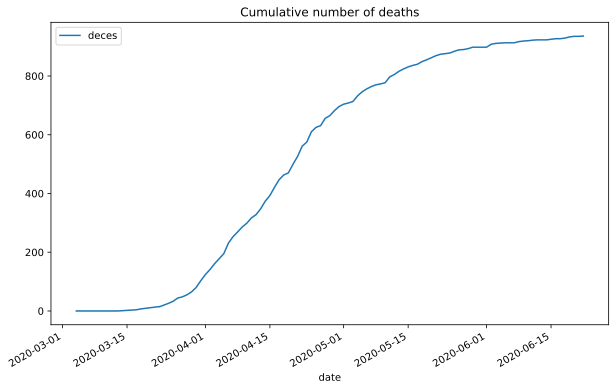

In [14]:
fig, ax = plt.subplots(figsize=figsize)
df_loc.plot(x='date', y='deces', ax=ax)
ax.set_title('Cumulative number of deaths');

### returning a numpy array

In [15]:
death = np.array(df_loc['deces'])
df_loc['date'], death

(439     2020-03-04
 537     2020-03-05
 663     2020-03-06
 770     2020-03-07
 874     2020-03-08
            ...    
 14405   2020-06-18
 14526   2020-06-19
 14647   2020-06-20
 14768   2020-06-21
 14889   2020-06-22
 Name: date, Length: 117, dtype: datetime64[ns],
 array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,
          7.,   7.,   9.,   9.,  11.,  11.,  13.,  13.,  15.,  14.,  20.,
         20.,  26.,  26.,  33.,  33.,  44.,  44.,  48.,  55.,  65.,  80.,
        103., 124., 141., 161., 178., 195., 231., 253., 269., 286., 299.,
        317., 328., 348., 374., 393., 421., 447., 463., 470., 499., 526.,
        561., 575., 610., 625., 631., 656., 665., 682., 696., 704., 708.,
        713., 732., 746., 756., 764., 770., 773., 777., 797., 805., 816.,
        824., 831., 836., 840., 849., 855., 862., 869., 874., 876., 878.,
        884., 889., 890., 893., 898., 898., 898., 898., 908., 911., 912.,
        913., 913., 913., 917., 919., 920., 922., 923., 923., 923

In [16]:
death.shape, np.diff(death).shape

((117,), (116,))

In [17]:
death[1:] = np.diff(death)
death[0] = 0

In [18]:
death

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  3.,  0.,
        2.,  0.,  2.,  0.,  2.,  0.,  2., -1.,  6.,  0.,  6.,  0.,  7.,
        0., 11.,  0.,  4.,  7., 10., 15., 23., 21., 17., 20., 17., 17.,
       36., 22., 16., 17., 13., 18., 11., 20., 26., 19., 28., 26., 16.,
        7., 29., 27., 35., 14., 35., 15.,  6., 25.,  9., 17., 14.,  8.,
        4.,  5., 19., 14., 10.,  8.,  6.,  3.,  4., 20.,  8., 11.,  8.,
        7.,  5.,  4.,  9.,  6.,  7.,  7.,  5.,  2.,  2.,  6.,  5.,  1.,
        3.,  5.,  0.,  0.,  0., 10.,  3.,  1.,  1.,  0.,  0.,  4.,  2.,
        1.,  2.,  1.,  0.,  0.,  2.,  2.,  0.,  2.,  4.,  2.,  0.,  1.])

In [19]:
df_loc['death'] = death
df_loc

,date,deces,death
439,2020-03-04,0.0,0.0
537,2020-03-05,0.0,0.0
663,2020-03-06,0.0,0.0
770,2020-03-07,0.0,0.0
874,2020-03-08,0.0,0.0
...,...,...,...
14405,2020-06-18,929.0,2.0
14526,2020-06-19,933.0,4.0
14647,2020-06-20,935.0,2.0
14768,2020-06-21,935.0,0.0


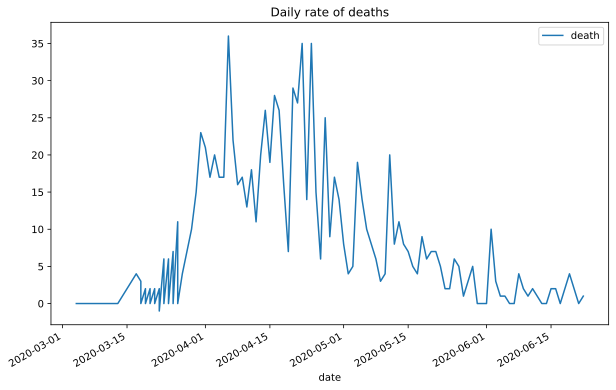

In [20]:
fig, ax = plt.subplots(figsize=figsize)
df_loc.plot(x='date', y='death', ax=ax)
ax.set_title('Daily rate of deaths');

## performing the fit

### converting data to fit

In [21]:
X, y = df_loc['date'], df_loc['death']

In [22]:
X.shape, y.shape

((117,), (117,))

In [23]:
X = X.astype(int)
X = np.array(X)
X

array([1583280000000000000, 1583366400000000000, 1583452800000000000,
       1583539200000000000, 1583625600000000000, 1583712000000000000,
       1583798400000000000, 1583884800000000000, 1583971200000000000,
       1584057600000000000, 1584403200000000000, 1584489600000000000,
       1584489600000000000, 1584576000000000000, 1584576000000000000,
       1584662400000000000, 1584662400000000000, 1584748800000000000,
       1584748800000000000, 1584835200000000000, 1584835200000000000,
       1584921600000000000, 1584921600000000000, 1585008000000000000,
       1585008000000000000, 1585094400000000000, 1585094400000000000,
       1585180800000000000, 1585180800000000000, 1585267200000000000,
       1585353600000000000, 1585440000000000000, 1585526400000000000,
       1585612800000000000, 1585699200000000000, 1585785600000000000,
       1585872000000000000, 1585958400000000000, 1586044800000000000,
       1586131200000000000, 1586217600000000000, 1586304000000000000,
       1586390400000

In [24]:
INTS_PER_DAY = 86400000000000 

In [25]:
X = (X-X[0])//INTS_PER_DAY

In [26]:
np.array(X)
X

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  13,  14,  14,
        15,  15,  16,  16,  17,  17,  18,  18,  19,  19,  20,  20,  21,
        21,  22,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110])

In [27]:
y = np.array(y)
y

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  3.,  0.,
        2.,  0.,  2.,  0.,  2.,  0.,  2., -1.,  6.,  0.,  6.,  0.,  7.,
        0., 11.,  0.,  4.,  7., 10., 15., 23., 21., 17., 20., 17., 17.,
       36., 22., 16., 17., 13., 18., 11., 20., 26., 19., 28., 26., 16.,
        7., 29., 27., 35., 14., 35., 15.,  6., 25.,  9., 17., 14.,  8.,
        4.,  5., 19., 14., 10.,  8.,  6.,  3.,  4., 20.,  8., 11.,  8.,
        7.,  5.,  4.,  9.,  6.,  7.,  7.,  5.,  2.,  2.,  6.,  5.,  1.,
        3.,  5.,  0.,  0.,  0., 10.,  3.,  1.,  1.,  0.,  0.,  4.,  2.,
        1.,  2.,  1.,  0.,  0.,  2.,  2.,  0.,  2.,  4.,  2.,  0.,  1.])

### using torch
or "when you have a new hammer, everything looks like a nail, seehttps://en.wikipedia.org/wiki/Law_of_the_instrument

Let's use the definition of the pdf:

$$
f ( x ; \mu , \lambda ) = \sqrt {\frac {\lambda }{2\pi x^3}} 
\exp (-\frac {\lambda (x-\mu )^{2}}{2\mu ^{2}x} )
$$

and a previous post where I used pyTorch to [fit psychophysical data](https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html):

In [28]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.MSELoss(reduction="sum")
# https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
#criterion = torch.nn.L1Loss(reduction="sum")


class CovidRegressionModel(torch.nn.Module):
    def __init__(self, mu=80, tau=24, 
                 log_amp=torch.log(500*torch.ones(1)),
                 log_lambda=torch.log(100*torch.ones(1)),
                ):
        super(CovidRegressionModel, self).__init__()
        self.tau = torch.nn.Parameter(tau * torch.ones(1))
        self.mu = torch.nn.Parameter(mu * torch.ones(1))
        # when modeling a stricly positive number, a good habit is to use their log as the fitted parameter:
        self.log_amp = torch.nn.Parameter(log_amp * torch.ones(1))
        self.log_lambda = torch.nn.Parameter(log_lambda * torch.ones(1))

    def forward(self, x):
        out = (x > self.tau) * torch.exp(self.log_amp)
        date = (x-self.tau) # 
        date[x<=self.tau] = 1 # to avoid NaNs in the output value (and in the gradient)
        out *= torch.sqrt(torch.exp(self.log_lambda) / (2 * np.pi * date ** 3)) 
        out *= torch.exp(-torch.exp(self.log_lambda) * (date - self.mu) ** 2 / (2 * self.mu ** 2 * date))
        out[x<=self.tau] = 0 # overwriting values before the onset
        return out

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 16
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

def fit_data(
    X,
    y,
    learning_rate=learning_rate,
    batch_size=batch_size,  # gamma=gamma,
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    variables, labels = torch.Tensor(X[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(variables, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    covid_model = CovidRegressionModel()
    covid_model = covid_model.to(device)
    covid_model.train()
    optimizer = torch.optim.Adam(
        covid_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        covid_model.train()
        losses = []
        for variables_, labels_ in loader:
            variables_, labels_ = variables_.to(device), labels_.to(device)
            outputs = covid_model(variables_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(variables):.5f}")

    covid_model.eval()
    variables, labels = torch.Tensor(X[:, None]), torch.Tensor(y[:, None])
    outputs = covid_model(variables)
    loss = criterion(outputs, labels).item() / len(variables)
    return covid_model, loss

/opt/homebrew/lib/python3.11/site-packages/torch/__init__.py:644: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [29]:
covid_model, loss = fit_data(X, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 96.01552
Iteration: 16 - Loss: 55.05382
Iteration: 32 - Loss: 33.63026
Iteration: 48 - Loss: 31.41670
Iteration: 64 - Loss: 30.84797
Iteration: 80 - Loss: 30.46070
Iteration: 96 - Loss: 30.13998
Iteration: 112 - Loss: 29.84471
Iteration: 128 - Loss: 29.59546
Iteration: 144 - Loss: 29.41575
Iteration: 160 - Loss: 29.23021
Iteration: 176 - Loss: 29.09775
Iteration: 192 - Loss: 28.98320
Iteration: 208 - Loss: 28.86144
Iteration: 224 - Loss: 28.80978
Iteration: 240 - Loss: 28.71954
Iteration: 256 - Loss: 28.67892
Iteration: 272 - Loss: 28.64720
Iteration: 288 - Loss: 28.53100
Iteration: 304 - Loss: 28.48683
Iteration: 320 - Loss: 28.44014
Iteration: 336 - Loss: 28.41868
Iteration: 352 - Loss: 28.37776
Iteration: 368 - Loss: 28.36485
Iteration: 384 - Loss: 28.33324
Iteration: 400 - Loss: 28.32159
Iteration: 416 - Loss: 28.30209
Iteration: 432 - Loss: 28.26682
Iteration: 448 - Loss: 28.24196
Iteration: 464 - Loss: 28.22982
Iteration: 480 - Loss: 28.21179
Iteration: 496 -

In [30]:
covid_model.eval()
outputs = covid_model(torch.Tensor(X[:, None]))
y_pred = outputs.detach().numpy()

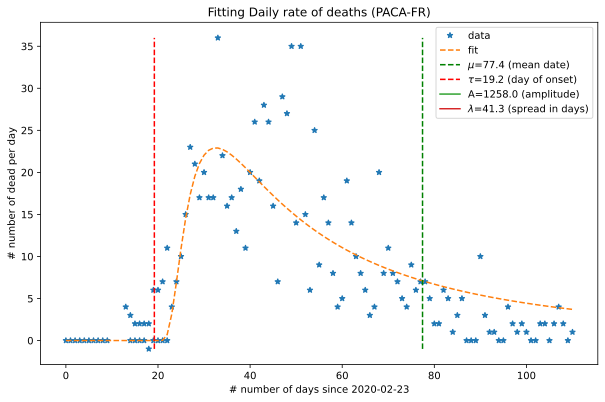

In [31]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(X, y, '*', label='data')
ax.plot(X, y_pred, '--', label='fit')
ax.vlines(covid_model.mu.item(), y.min(), y.max(), colors='g', linestyles='--', label=f'$\mu$={covid_model.mu.item():.1f} (mean date)')
ax.vlines(covid_model.tau.item(), y.min(), y.max(), colors='r', linestyles='--', label=fr'$\tau$={covid_model.tau.item():.1f} (day of onset)')
ax.plot([], [], label=f'A={torch.exp(covid_model.log_amp).item():.1f} (amplitude)')
ax.plot([], [], label=f'$\lambda$={torch.exp(covid_model.log_lambda).item():.1f} (spread in days)')
ax.legend()
ax.set_xlabel(f'# number of days since {start_date}');
ax.set_ylabel(f'# number of dead per day');
ax.set_title('Fitting Daily rate of deaths (PACA-FR)');

## some book keeping for the notebook

In [32]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,pandas,matplotlib,torch  -r -g -b

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.17.2

numpy     : 1.26.2
pandas    : 2.1.2
matplotlib: 3.8.1
torch     : 2.2.0.dev20231107

Compiler    : Clang 15.0.0 (clang-1500.0.40.1)
OS          : Darwin
Release     : 23.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Hostname: obiwan.local

Git hash: 7d922159a79b47a09772bc8a4723e12d56b4af78

Git repo: https://github.com/laurentperrinet/sciblog

Git branch: master

